# Least-Squares Background Fitting
We attempt to fit a range of polynomial functions to the background using a linear least-squares fitting routine as implemented by SciPy. This is a binned fitting routine. Optimised parameters are retained in this notebook and in the more general data directory.

In [5]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [14]:
LOW_MASS = 4500
HIGH_MASS = 6500

In [10]:
def bayesian_blocks(t):
    """Bayesian Blocks Implementation
    Based on algorithm outlined in http://adsabs.harvard.edu/abs/2012arXiv1207.5578S

    Parameters
    ----------
    t : ndarray, length N
        data to be histogrammed

    Returns
    -------
    bins : ndarray
        array containing the (N+1) bin edges

    Notes
    -----
    This is an incomplete implementation: it may fail for some
    datasets.  Alternate fitness functions and prior forms can
    be found in the paper listed above.
    """
    # copy and sort the array
    t = np.sort(t)
    N = t.size

    # create length-(N + 1) array of cell edges
    edges = np.concatenate([t[:1], 0.5 * (t[1:] + t[:-1]), t[-1:]])
    block_length = t[-1] - edges

    # arrays needed for the iteration
    nn_vec = np.ones(N)
    best = np.zeros(N, dtype=float)
    last = np.zeros(N, dtype=int)

    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------
    for K in range(N):
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width = block_length[:K + 1] - block_length[K + 1]
        count_vec = np.cumsum(nn_vec[:K + 1][::-1])[::-1]

        # evaluate fitness function for these possibilities
        fit_vec = count_vec * (np.log(count_vec) - np.log(width))
        fit_vec -= 4  # 4 comes from the prior on the number of changepoints
        fit_vec[1:] += best[:K]

        # find the max of the fitness: this is the K^th changepoint
        i_max = np.argmax(fit_vec)
        last[K] = i_max
        best[K] = fit_vec[i_max]

    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------
    change_points =  np.zeros(N, dtype=int)
    i_cp = N
    ind = N
    while True:
        i_cp -= 1
        change_points[i_cp] = ind
        if ind == 0:
            break
        ind = last[ind - 1]
    change_points = change_points[i_cp:]

    return edges[change_points]

## Fetch Mass Distribution
We need to construct an actual background mass distribution to fit from. We will use the background data as given in the real tuple and restrict the sidebands to the values the neural network is currently using. We will also want to try the optimisation using a variety of bin widths.

In [52]:
sf = pd.read_csv('../data_files/8.0.1/all.csv', index_col=[0])
df = pd.read_csv('../data_files/8.0.0/all.csv', index_col=[0])
# Note these data have not been normalised like the training, validation and test CSVs

## Bin the Distribution
Now that we have a dataframe with all the background events we care about it is now prudent to fit our background functions to this. Before doing this these data should be put into bins. The value of bins is variable and will affect the final fit. For this reason we choose the finest bin structure possible.

In [53]:
df = df[df['Lb_M'].between(LOW_MASS, HIGH_MASS)]
sf = sf[sf['Lb_M'].between(LOW_MASS, HIGH_MASS)]
# Apply the mass range restriction

masses = df['Lb_M'][df['category'] == 0 and df['IsSimulated'] == False].to_numpy()
masses_pre = sf['Lb_M'][sf['category'] == 0 and df['IsSimulated'] == False].to_numpy()
# Only keep background events

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Visual Analysis
The best way to get a feel for these data is to do an initial visual analysis. We can do this by plotting the mass distribution and seeing what sort of shape it seems to take. We might normally expect a combinatorial background to be exponentially decaying excluding any resonances.

In [49]:
h, bins = np.histogram(masses, bins=100)
hpre, _ = np.histogram(masses_pre, bins=bins)

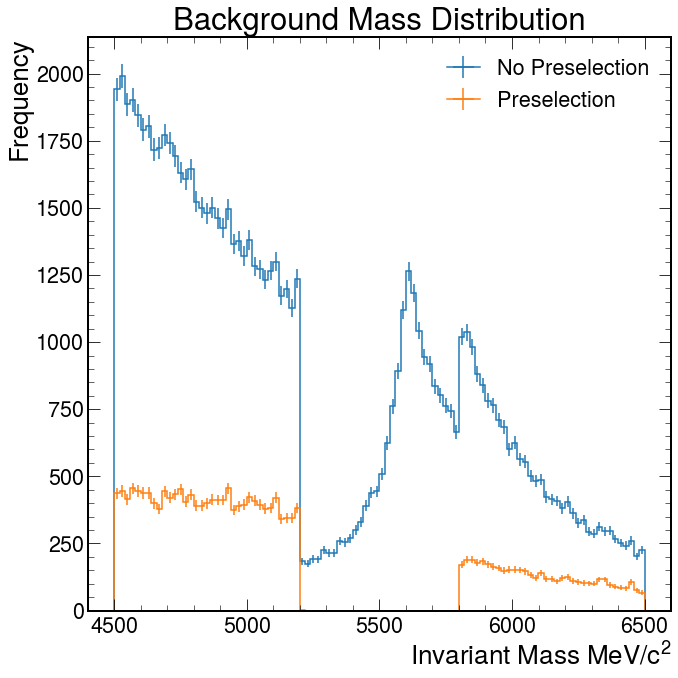

In [51]:
fig, ax = plt.subplots(1, 1)
ax.set_title(f"Background Mass Distribution")
hep.histplot([h, hpre], bins, yerr=[np.sqrt(hpre), np.sqrt(h)], ax=ax, label=['No Preselection', 'Preselection'])
#ax.hist(df['Lb_M'], bins=blocks, label='Bayesian Blocks', histtype='step')
plt.ylabel('Frequency', horizontalalignment='right', y=1.0)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0)
ax.legend()
plt.tight_layout()
#plt.savefig('../images/BackgroundFits/Mass_Distribution.png', dpi=800)
plt.show()

## Fitting Polynomials

In [41]:
def quadratic(x, N, A, b, c):
    return N*(A*(x**2) + (b*x) + c)

d = np.array([[np.mean(bins[i:i+2]) for i in range(len(bins)-1)], h, np.sqrt(h)]).T
d = d[(d[:,1] >= 10)]

popt, pcov = curve_fit(quadratic, d[:,0], d[:,1], [1e-2, 1e-3, -5, 5e4], d[:,2], absolute_sigma=True)
# Do the optimisation

func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
print(popt)

[ 2.44251065e-01  2.26331016e-03 -2.95953991e+01  9.75510769e+04]


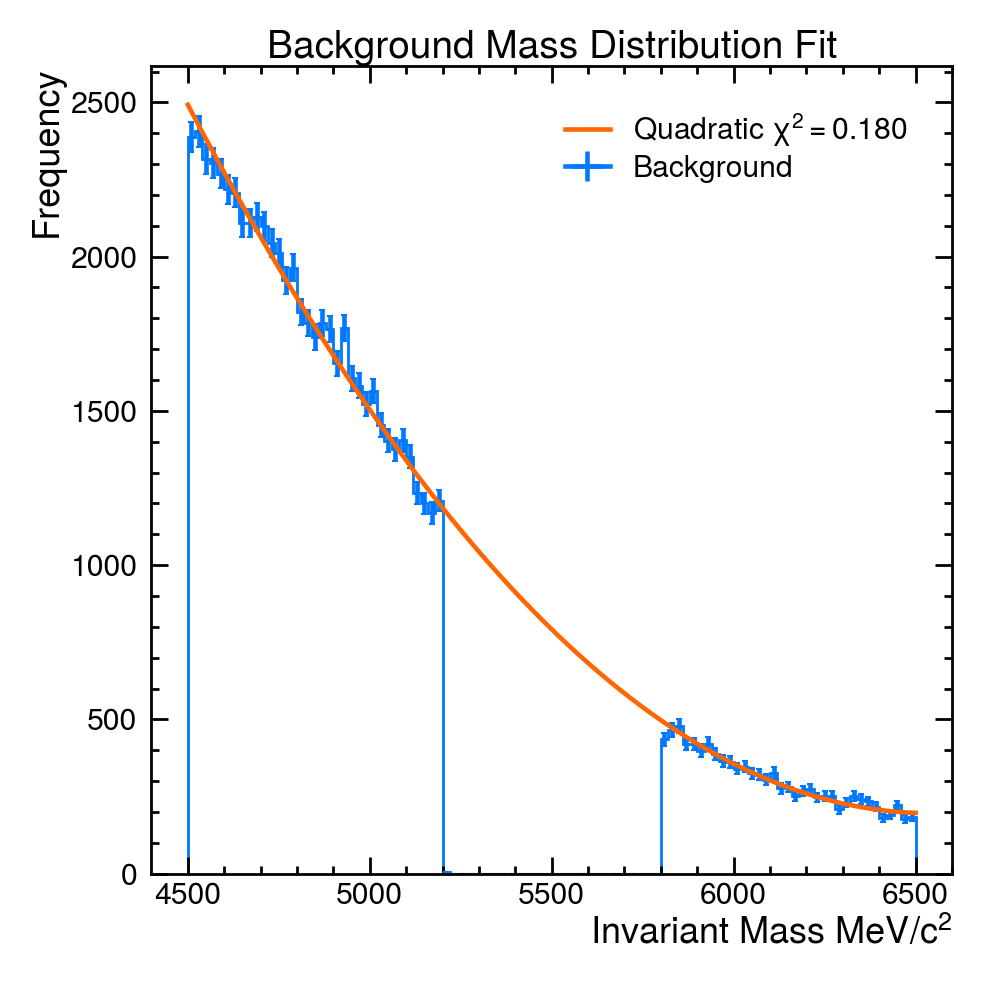

In [48]:
fig, ax = plt.subplots(1, 1)
ax.set_title(f"Background Mass Distribution Fit")
hep.histplot(h, bins, yerr=np.sqrt(h), ax=ax, label='Background')
ax.plot(func_x, quadratic(func_x, *popt), label=r'Quadratic $\chi^2=0.180$')
plt.ylabel('Frequency', horizontalalignment='right', y=1.0)
plt.xlabel(r'Invariant Mass MeV$/c^2$', horizontalalignment='right', x=1.0)
ax.legend()
plt.tight_layout()
plt.savefig('../images/BackgroundFits/Mass_Distribution_Quadratic_Fit.png', dpi=800)
plt.show()

# Goodness of Fit Tests

In [43]:
from scipy.stats import chi2
from scipy.stats import ks_2samp

In [44]:
pred = quadratic(d[:,0], *popt)
chi = np.sum(((d[:,1] - pred)/d[:,2]**2)**2)
chi

0.18023421510866328

We expect chi2 to be distributed according to a chi-square distribution with $\nu=N-p$ d.o.f. I.e. see table in Inference notes that says for $\alpha=0.1$ these values of S should only be exceeded with probability 0.1 if the model is indeed correct.

In [46]:
chi2.ppf(0.05, df=len(pred)-3)

49.16227017917681

In [47]:
ks, kspvalue = ks_2samp(d[:,1], pred)
ks, kspvalue

(0.05714285714285714, 0.9998859703191283)

Very high p-value and small statistic for the KS tests informs us that we cannot reject the null hypothesis. I.e. the two distributions are identical with a 99.99% confidence.